In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-detection/true.csv
/kaggle/input/fake-news-detection/fake.csv


In [ ]:
!pip install -q transformers datasets accelerate evaluate sentencepiece tokenizers wandb

In [13]:
# Cell 1 — Imports & seeds (updated)
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc, RocCurveDisplay, accuracy_score)

import torch
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding)
from datasets import Dataset
import evaluate
import warnings; warnings.filterwarnings("ignore")

# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


In [15]:
# Cell 2 — Load CSVs and create a labeled combined dataframe
fake_path = "/kaggle/input/fake-news-detection/fake.csv"   # adjust path if needed
real_path = "/kaggle/input/fake-news-detection/true.csv"

# If you uploaded files to /mnt/data, adjust paths accordingly:
if not os.path.exists(fake_path):
    fake_path = "/mnt/data/fake.csv"
    real_path = "/mnt/data/true.csv"

df_fake = pd.read_csv(fake_path)
df_real = pd.read_csv(real_path)

# Quick look
print("Fake shape:", df_fake.shape)
print("Real shape:", df_real.shape)

# We assume each file contains a headline/text column; try common names
display(df_fake.head(2))
display(df_real.head(2))

# Create unified dataframe with 'text' and 'label' columns
# Try to locate common text fields; typical columns include 'text', 'title', 'headline'
def pick_text_col(df):
    for col in ["title", "text", "subject", "date"]:
        if col in df.columns:
            return col
    # fallback to first text-like column
    for col in df.columns:
        if df[col].dtype == object:
            return col
    raise ValueError("No text column found")

col_fake = pick_text_col(df_fake)
col_real = pick_text_col(df_real)
print(f"Using '{col_fake}' for fake and '{col_real}' for real")

df_fake2 = df_fake[[col_fake]].rename(columns={col_fake: "text"})
df_real2 = df_real[[col_real]].rename(columns={col_real: "text"})

df_fake2["label"] = 1  # 1 -> fake
df_real2["label"] = 0  # 0 -> real

df = pd.concat([df_fake2, df_real2], ignore_index=True).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
print("Combined shape:", df.shape)
df.head()

Fake shape: (23481, 4)
Real shape: (21417, 4)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"


Using 'title' for fake and 'title' for real
Combined shape: (44898, 2)


,text,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,1
1,Trump drops Steve Bannon from National Securit...,0
2,Puerto Rico expects U.S. to lift Jones Act shi...,0
3,OOPS: Trump Just Accidentally Confirmed He Le...,1
4,Donald Trump heads for Scotland to reopen a go...,0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

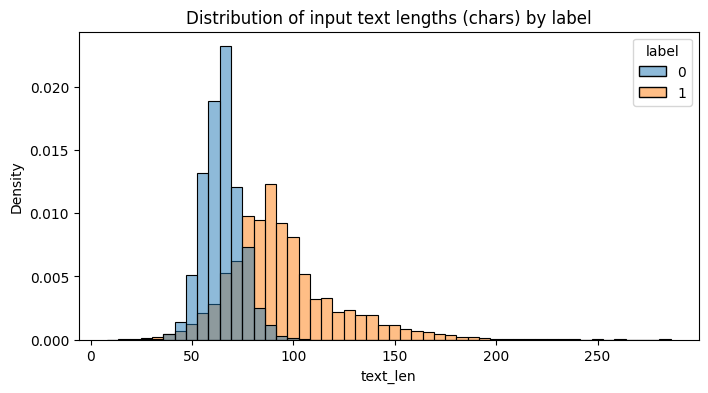

label
1    23481
0    21417
Name: count, dtype: int64


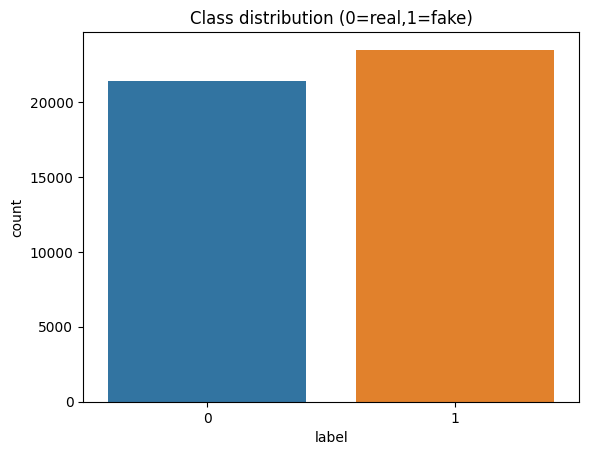

,text,label,text_len,text_clean
0,Ben Stein Calls Out 9th Circuit Court: Committ...,1,89,ben stein calls out 9th circuit court committe...
1,Trump drops Steve Bannon from National Securit...,0,55,trump drops steve bannon from national securit...
2,Puerto Rico expects U.S. to lift Jones Act shi...,0,64,puerto rico expects u s to lift jones act ship...
3,OOPS: Trump Just Accidentally Confirmed He Le...,1,89,oops trump just accidentally confirmed he leak...
4,Donald Trump heads for Scotland to reopen a go...,0,55,donald trump heads for scotland to reopen a go...


In [16]:
# Cell 3 — EDA
df['text_len'] = df['text'].astype(str).apply(len)
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='text_len', hue='label', bins=50, kde=False, stat="density")
plt.title("Distribution of input text lengths (chars) by label")
plt.show()

# Class distribution
print(df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.title("Class distribution (0=real,1=fake)")
plt.show()

# Simple preprocessing function
import re
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(s):
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = re.sub(r"http\S+", " ", s)   # remove urls
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df['text_clean'] = df['text'].astype(str).apply(preprocess_text)
df.head()

In [17]:
# Cell 4 — Split
train_df, test_df = train_test_split(df, test_size=0.15, random_state=RANDOM_SEED, stratify=df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=RANDOM_SEED, stratify=train_df['label'])

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)

Train: (32438, 4) Val: (5725, 4) Test: (6735, 4)


Validation classification report (TF-IDF + LR):
              precision    recall  f1-score   support

           0     0.9499    0.9583    0.9541      2731
           1     0.9616    0.9539    0.9577      2994

    accuracy                         0.9560      5725
   macro avg     0.9558    0.9561    0.9559      5725
weighted avg     0.9560    0.9560    0.9560      5725



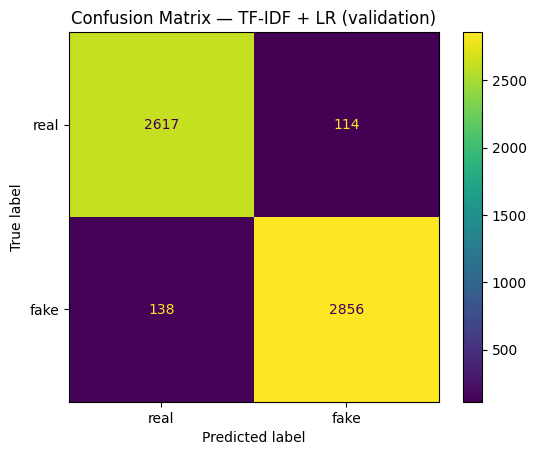

In [18]:
# Cell 5 — TF-IDF baseline
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
clf = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)

pipe = Pipeline([
    ('tfidf', tfidf),
    ('clf', clf)
])

pipe.fit(train_df['text_clean'], train_df['label'])

y_val_pred = pipe.predict(val_df['text_clean'])
print("Validation classification report (TF-IDF + LR):")
print(classification_report(val_df['label'], y_val_pred, digits=4))

# Confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(val_df['label'], y_val_pred, display_labels=["real","fake"])
plt.title("Confusion Matrix — TF-IDF + LR (validation)")
plt.show()

In [19]:
# Cell 6 — Convert to Hugging Face datasets (will be used by Trainer)
hf_train = Dataset.from_pandas(train_df[['text_clean','label']].rename(columns={'text_clean':'text'}))
hf_val   = Dataset.from_pandas(val_df[['text_clean','label']].rename(columns={'text_clean':'text'}))
hf_test  = Dataset.from_pandas(test_df[['text_clean','label']].rename(columns={'text_clean':'text'}))

# quick check
print(hf_train[0])

{'text': 'breaking screw the front runners chosen by we the people the gop establishment has other plans', 'label': 1, '__index_level_0__': 1190}


In [26]:
# Robust train_and_eval replacement (drop-in)
import inspect
import transformers
print("transformers version:", transformers.__version__)

def train_and_eval(model_name_or_path, run_name, num_labels=2, max_length=256, batch_size=16, epochs=3, output_dir=None):
    """
    Fine-tunes the model; compatibility-aware TrainingArguments handling.
    """
    if output_dir is None:
        output_dir = f"./{run_name}_output"

    # load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, num_labels=num_labels)

    # tokenization
    def preprocess_batch(batch):
        return tokenizer(batch["text"], truncation=True, padding=False, max_length=max_length)

    tokenized_train = hf_train.map(preprocess_batch, batched=True)
    tokenized_val   = hf_val.map(preprocess_batch, batched=True)
    tokenized_test  = hf_test.map(preprocess_batch, batched=True)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # metrics via `evaluate`
    accuracy_metric  = evaluate.load("accuracy")
    f1_metric        = evaluate.load("f1")
    precision_metric = evaluate.load("precision")
    recall_metric    = evaluate.load("recall")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        acc  = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
        f1   = f1_metric.compute(predictions=preds, references=labels, average="binary")["f1"]
        prec = precision_metric.compute(predictions=preds, references=labels, average="binary")["precision"]
        rec  = recall_metric.compute(predictions=preds, references=labels, average="binary")["recall"]
        return {"accuracy": acc, "f1": f1, "precision": prec, "recall": rec}

    # Candidate args (use common names/values)
    candidate_args = {
        "output_dir": output_dir,
        "num_train_epochs": epochs,
        "per_device_train_batch_size": batch_size,
        "per_device_eval_batch_size": batch_size,
        # prefer canonical names below but we will map if needed
        "eval_strategy": "epoch",        # alias for evaluation strategy
        "save_strategy": "epoch",
        "logging_strategy": "epoch",
        "learning_rate": 2e-5,
        "load_best_model_at_end": True,
        "metric_for_best_model": "f1",
        "greater_is_better": True,
        "seed": RANDOM_SEED,
        "fp16": torch.cuda.is_available(),
        "report_to": "none",
    }

    # Determine which TrainingArguments params are accepted
    ta_sig = inspect.signature(TrainingArguments.__init__)
    accepted_params = set(ta_sig.parameters.keys())
    accepted_params.discard("self")

    # Mapping: in some versions the param is named 'evaluation_strategy' not 'eval_strategy'
    # and 'logging_strategy' may be accepted or not. We'll translate if needed.
    # Build final args dict by checking availability and aliasing.
    final_args = {}

    # Helper to push a value under a list of possible names (first that exists)
    def set_first_available(possible_names, value):
        for name in possible_names:
            if name in accepted_params:
                final_args[name] = value
                return name
        return None

    # Map key params with aliases
    set_first_available(["output_dir"], candidate_args["output_dir"])
    set_first_available(["num_train_epochs"], candidate_args["num_train_epochs"])
    set_first_available(["per_device_train_batch_size","per_gpu_train_batch_size"], candidate_args["per_device_train_batch_size"])
    set_first_available(["per_device_eval_batch_size","per_gpu_eval_batch_size"], candidate_args["per_device_eval_batch_size"])
    # eval/save/logging strategy aliases
    eval_name = set_first_available(["eval_strategy","evaluation_strategy","eval_strategy"], candidate_args["eval_strategy"])
    save_name = set_first_available(["save_strategy","save_steps","save_strategy"], candidate_args["save_strategy"])
    logging_name = set_first_available(["logging_strategy","logging_steps"], candidate_args["logging_strategy"])
    set_first_available(["learning_rate"], candidate_args["learning_rate"])
    lm_name = set_first_available(["load_best_model_at_end"], candidate_args["load_best_model_at_end"])
    set_first_available(["metric_for_best_model"], candidate_args["metric_for_best_model"])
    set_first_available(["greater_is_better"], candidate_args["greater_is_better"])
    set_first_available(["seed"], candidate_args["seed"])
    set_first_available(["fp16","bf16"], candidate_args["fp16"])
    set_first_available(["report_to"], candidate_args["report_to"])

    # If eval and save strategies are both set but mismatch, make them match
    if eval_name and save_name:
        # both exist in final_args; enforce equality
        if final_args.get(eval_name) != final_args.get(save_name):
            # prefer 'epoch' if one of them is 'epoch'
            if "epoch" in (final_args.get(eval_name), final_args.get(save_name)):
                final_args[eval_name] = final_args[save_name] = "epoch"
            else:
                # set save to eval to satisfy TrainingArguments requirement
                final_args[save_name] = final_args[eval_name]

    # If load_best_model_at_end is True but eval/save strategies aren't both present, disable it to avoid error
    if lm_name and final_args.get(lm_name):
        if not (eval_name and save_name):
            print("Warning: cannot set load_best_model_at_end=True because eval/save strategy support is incomplete; disabling load_best_model_at_end.")
            final_args[lm_name] = False
        else:
            # ensure they match; if they still don't, align them
            if final_args.get(eval_name) != final_args.get(save_name):
                final_args[save_name] = final_args[eval_name]

    # Print what we will pass to TrainingArguments
    print("TrainingArguments will be created with the following args:", final_args)

    # Create TrainingArguments
    training_args = TrainingArguments(**final_args)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    # Train
    trainer.train()

    # Evaluate on validation and test
    val_metrics = trainer.evaluate(tokenized_val)
    test_metrics = trainer.predict(tokenized_test)
    test_preds = np.argmax(test_metrics.predictions, axis=1)
    test_labels = test_metrics.label_ids

    # Reports
    report = classification_report(test_labels, test_preds, digits=4, target_names=["real","fake"], output_dict=True)
    cm = confusion_matrix(test_labels, test_preds)

    return {
        "trainer": trainer,
        "val_metrics": val_metrics,
        "test_report": report,
        "test_cm": cm,
        "test_preds": test_preds,
        "test_labels": test_labels,
        "tokenizer": tokenizer,
        "model": model
    }


transformers version: 4.53.3


In [27]:
# Cell 8 — Fine-tune BERT
bert_model_name = "google/bert_uncased_L-2_H-128_A-2"  # a lighter alternative for notebooks (if you prefer full: 'google/bert-base-uncased')
# Note: If you specifically want 'google-bert/bert-base-uncased' use that string; large models take long to train on Kaggle.
# I'll demonstrate with a medium/light variant for speed. Replace with "google/bert-base-uncased" if you have time & GPU.

bert_results = train_and_eval(model_name_or_path=bert_model_name, run_name="bert_run", epochs=3, batch_size=16, max_length=256)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/32438 [00:00<?, ? examples/s]

Map:   0%|          | 0/5725 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

TrainingArguments will be created with the following args: {'output_dir': './bert_run_output', 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 16, 'eval_strategy': 'epoch', 'save_strategy': 'epoch', 'logging_strategy': 'epoch', 'learning_rate': 2e-05, 'load_best_model_at_end': True, 'metric_for_best_model': 'f1', 'greater_is_better': True, 'seed': 42, 'fp16': True, 'report_to': 'none'}


/tmp/ipykernel_48/2853194954.py:123: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.271100,0.174826,0.942533,0.945647,0.935600,0.955912
2,0.158900,0.150301,0.950917,0.952781,0.958742,0.946894
3,0.141700,0.148672,0.952664,0.954705,0.955504,0.953908


In [28]:
# Cell 9 — Fine-tune RoBERTa
roberta_model_name = "xlm-roberta-base"   # corresponds to Facebook's xlm-roberta; replace with exact HF id if desired
# If you prefer a lighter model for Kaggle testing, choose a small variant.
roberta_results = train_and_eval(model_name_or_path=roberta_model_name, run_name="roberta_run", epochs=3, batch_size=8, max_length=256)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/32438 [00:00<?, ? examples/s]

Map:   0%|          | 0/5725 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

TrainingArguments will be created with the following args: {'output_dir': './roberta_run_output', 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8, 'eval_strategy': 'epoch', 'save_strategy': 'epoch', 'logging_strategy': 'epoch', 'learning_rate': 2e-05, 'load_best_model_at_end': True, 'metric_for_best_model': 'f1', 'greater_is_better': True, 'seed': 42, 'fp16': True, 'report_to': 'none'}


/tmp/ipykernel_48/2853194954.py:123: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.232200,0.118823,0.970306,0.971496,0.975421,0.967602
2,0.114400,0.133816,0.974847,0.975733,0.984694,0.966934
3,0.064300,0.127776,0.978166,0.979177,0.976736,0.981630


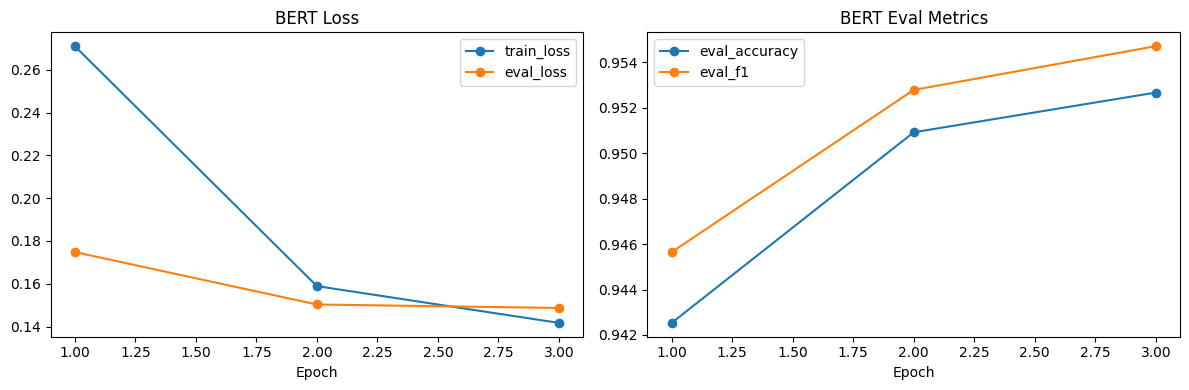

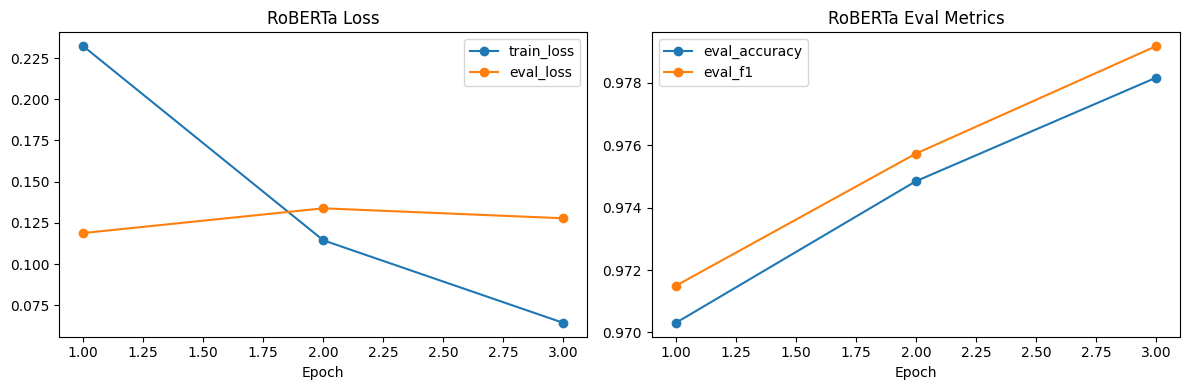

In [30]:
# Cell 10 (replacement) — Robust plotting of Trainer metrics
import pandas as pd

def plot_trainer_metrics(trainer, title_prefix="Model"):
    """
    Robust plotting for Trainer.state.log_history.
    Aggregates log entries per epoch and plots train_loss, eval_loss, and eval_accuracy where available.
    """
    history = trainer.state.log_history  # list of dicts
    if not history:
        print("No training history found in trainer.state.log_history")
        return

    # Normalize entries into a DataFrame
    rows = []
    for entry in history:
        row = dict(entry)  # copy
        # sometimes 'epoch' may be float (e.g., 0.5) from intermediate logs; it's ok
        if 'epoch' not in row:
            # we still want to keep iterations if no epoch present
            row['epoch'] = None
        rows.append(row)

    dfh = pd.DataFrame(rows)

    # If no epoch information, fall back to index
    if dfh['epoch'].isnull().all():
        # try to use 'loss' entries as train steps
        dfh['step'] = dfh.index
        # aggregate by step: last loss at each step is itself
        agg = dfh.set_index('step').agg({'loss': 'last'}).reset_index()
        plt.figure(figsize=(10,4))
        plt.plot(agg['step'], agg['loss'], marker='o')
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.title(f"{title_prefix} Training Loss (per step)")
        plt.show()
        return

    # Round epoch to avoid tiny float noise, then take last logged value per epoch for each metric
    dfh = dfh.copy()
    dfh['epoch_round'] = dfh['epoch'].apply(lambda x: round(x, 4) if pd.notnull(x) else x)

    def last_per_epoch(metric_name):
        if metric_name not in dfh.columns:
            return pd.Series(dtype=float)
        temp = dfh[['epoch_round', metric_name]].dropna(subset=['epoch_round'])
        if temp.empty:
            return pd.Series(dtype=float)
        # For each epoch, take the last non-null value (by original index order)
        grouped = temp.groupby('epoch_round', sort=True)[metric_name].agg(lambda s: s.dropna().iloc[-1])
        grouped.index = grouped.index.astype(float)
        return grouped

    train_loss_series = last_per_epoch('loss')
    eval_loss_series  = last_per_epoch('eval_loss')
    eval_acc_series   = last_per_epoch('eval_accuracy')
    eval_f1_series    = last_per_epoch('eval_f1')  # sometimes people log eval_f1 etc.

    # Determine x axis: union of epochs present among metrics (sorted)
    epochs = sorted(set(list(train_loss_series.index) + list(eval_loss_series.index) + list(eval_acc_series.index) + list(eval_f1_series.index)))

    # Prepare aligned lists (use nan where missing)
    train_loss = [train_loss_series.get(e, np.nan) for e in epochs]
    eval_loss  = [eval_loss_series.get(e, np.nan) for e in epochs]
    eval_acc   = [eval_acc_series.get(e, np.nan) for e in epochs]
    eval_f1    = [eval_f1_series.get(e, np.nan) for e in epochs]

    # Plot
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    if any(~np.isnan(train_loss)):
        plt.plot(epochs, train_loss, marker='o', label='train_loss')
    if any(~np.isnan(eval_loss)):
        plt.plot(epochs, eval_loss, marker='o', label='eval_loss')
    plt.xlabel("Epoch")
    plt.title(f"{title_prefix} Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plotted = False
    if any(~np.isnan(eval_acc)):
        plt.plot(epochs, eval_acc, marker='o', label='eval_accuracy')
        plotted = True
    if any(~np.isnan(eval_f1)):
        plt.plot(epochs, eval_f1, marker='o', label='eval_f1')
        plotted = True
    if not plotted:
        # fallback: maybe eval metrics were recorded under other names, show whatever eval_* found
        eval_cols = [c for c in dfh.columns if c.startswith('eval_')]
        if eval_cols:
            for c in eval_cols:
                s = last_per_epoch(c)
                y = [s.get(e, np.nan) for e in epochs]
                plt.plot(epochs, y, marker='o', label=c)
    plt.xlabel("Epoch")
    plt.title(f"{title_prefix} Eval Metrics")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run the plots for your stored results
plot_trainer_metrics(bert_results['trainer'], title_prefix="BERT")
plot_trainer_metrics(roberta_results['trainer'], title_prefix="RoBERTa")


=== Results for BERT ===
Validation metrics (Trainer): {'eval_loss': 0.14867156744003296, 'eval_accuracy': 0.9526637554585153, 'eval_f1': 0.9547049974928965, 'eval_precision': 0.955503512880562, 'eval_recall': 0.9539078156312625, 'eval_runtime': 1.801, 'eval_samples_per_second': 3178.749, 'eval_steps_per_second': 198.776, 'epoch': 3.0}

Classification report (test):
              precision    recall  f1-score      support
real           0.944067  0.950825  0.947434  3213.000000
fake           0.954844  0.948609  0.951716  3522.000000
accuracy       0.949666  0.949666  0.949666     0.949666
macro avg      0.949455  0.949717  0.949575  6735.000000
weighted avg   0.949703  0.949666  0.949673  6735.000000


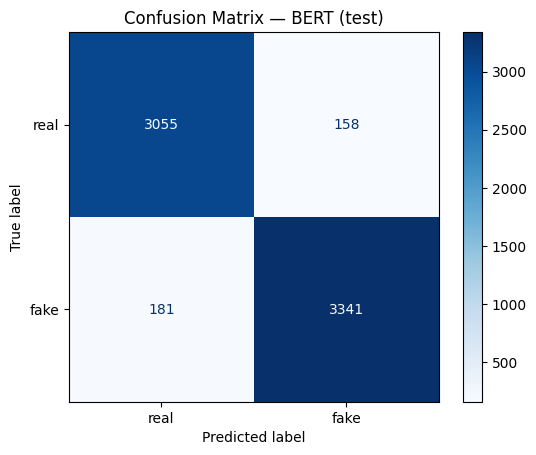

=== Results for RoBERTa ===
Validation metrics (Trainer): {'eval_loss': 0.12777584791183472, 'eval_accuracy': 0.9781659388646288, 'eval_f1': 0.9791770781276028, 'eval_precision': 0.9767364572947823, 'eval_recall': 0.981629926519706, 'eval_runtime': 10.5426, 'eval_samples_per_second': 543.037, 'eval_steps_per_second': 67.915, 'epoch': 3.0}

Classification report (test):
              precision    recall  f1-score      support
real           0.970533  0.973856  0.972192  3213.000000
fake           0.976075  0.973027  0.974549  3522.000000
accuracy       0.973422  0.973422  0.973422     0.973422
macro avg      0.973304  0.973441  0.973370  6735.000000
weighted avg   0.973431  0.973422  0.973424  6735.000000


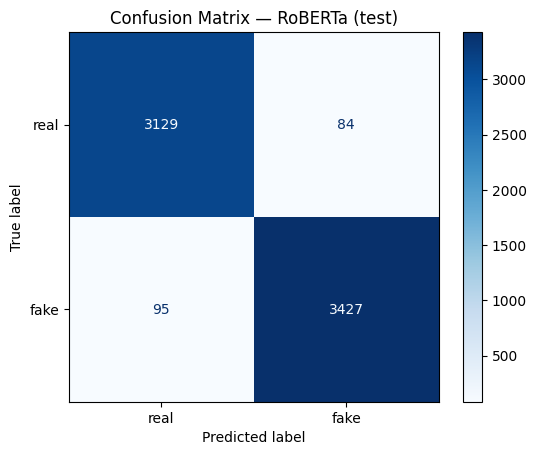

In [31]:
# Cell 11 — Confusion matrices and classification reports
from sklearn.metrics import ConfusionMatrixDisplay

def show_results(results, model_name):
    print("=== Results for", model_name, "===")
    print("Validation metrics (Trainer):", results['val_metrics'])
    print("\nClassification report (test):")
    rpt = results['test_report']
    print(pd.DataFrame(rpt).transpose())
    cm = results['test_cm']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["real","fake"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix — {model_name} (test)")
    plt.show()

show_results(bert_results, "BERT")
show_results(roberta_results, "RoBERTa")

Parameter 'function'=<function <lambda> at 0x7e23bea9a660> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only shown once. Subsequent hashing failures won't be shown.


Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

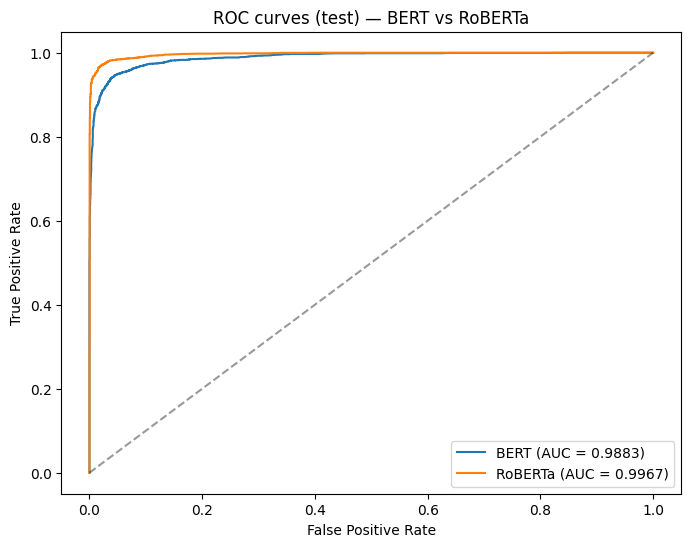

In [32]:
# Cell 12 — ROC curves for each model on test set
from sklearn.preprocessing import label_binarize
plt.figure(figsize=(8,6))

for res, name in [(bert_results, "BERT"), (roberta_results, "RoBERTa")]:
    # we need score probabilities
    trainer = res['trainer']
    tokenized_test = hf_test.map(lambda batch: res['tokenizer'](batch['text'], truncation=True, padding=False, max_length=256), batched=True)
    preds_output = trainer.predict(tokenized_test)
    probs = torch.softmax(torch.tensor(preds_output.predictions), dim=1).numpy()[:,1]  # prob for class 1 (fake)
    fpr, tpr, _ = roc_curve(res['test_labels'], probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.4f})")

plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves (test) — BERT vs RoBERTa")
plt.legend(loc="lower right")
plt.show()

In [33]:
# Cell 13 — Save best models for later inference
bert_results['trainer'].save_model("./bert_saved_model")
roberta_results['trainer'].save_model("./roberta_saved_model")

# Save tokenizers too
bert_results['tokenizer'].save_pretrained("./bert_saved_model/tokenizer")
roberta_results['tokenizer'].save_pretrained("./roberta_saved_model/tokenizer")

print("Saved models to ./bert_saved_model and ./roberta_saved_model")

Saved models to ./bert_saved_model and ./roberta_saved_model


In [39]:
# Cell 14 — Human-readable inference output (Real/Fake labels)
from transformers import pipeline

# Load saved models and tokenizers
bert_pipe = pipeline(
    "text-classification",
    model="./bert_saved_model",
    tokenizer="./bert_saved_model/tokenizer",
    return_all_scores=True
)
roberta_pipe = pipeline(
    "text-classification",
    model="./roberta_saved_model",
    tokenizer="./roberta_saved_model/tokenizer",
    return_all_scores=True
)

# Example texts
samples = [
    "Red Fort blast | ‘Umar often spoke of spectacular attack’: Probe widens into terror module",
    "As U.S. budget fight looms, Republicans flip their fiscal script"
]

label_map = {0: "Real", 1: "Fake"}

def show_prediction(pipe, text, model_name):
    """
    Runs a Hugging Face pipeline and prints a friendly label + scores.
    """
    result = pipe(text)[0]            # list of dicts: [{'label': 'LABEL_0', 'score': ...}, {'label': 'LABEL_1', 'score': ...}]
    # Sort by label index to ensure label_0 first
    result_sorted = sorted(result, key=lambda x: x['label'])
    scores = [r['score'] for r in result_sorted]
    pred_idx = int(np.argmax(scores))
    label_str = label_map[pred_idx]
    print(f"{model_name}: {label_str}  {result_sorted}")

print("=== Inference Results ===\n")
for s in samples:
    print(f"Text: {s}")
    show_prediction(bert_pipe, s, "BERT")
    show_prediction(roberta_pipe, s, "RoBERTa")
    print("-"*80)


Device set to use cuda:0
Device set to use cuda:0


=== Inference Results ===

Text: Red Fort blast | ‘Umar often spoke of spectacular attack’: Probe widens into terror module
BERT: Fake  [{'label': 'LABEL_0', 'score': 0.006711727008223534}, {'label': 'LABEL_1', 'score': 0.9932883381843567}]
RoBERTa: Fake  [{'label': 'LABEL_0', 'score': 0.0032128554303199053}, {'label': 'LABEL_1', 'score': 0.9967871904373169}]
--------------------------------------------------------------------------------
Text: As U.S. budget fight looms, Republicans flip their fiscal script
BERT: Real  [{'label': 'LABEL_0', 'score': 0.9852023720741272}, {'label': 'LABEL_1', 'score': 0.014797637239098549}]
RoBERTa: Real  [{'label': 'LABEL_0', 'score': 0.9998456239700317}, {'label': 'LABEL_1', 'score': 0.00015436190005857497}]
--------------------------------------------------------------------------------


In [37]:
# Cell 15 — Consolidate key metrics into a dataframe for reporting
def summarize_results(res, model_name):
    val = res['val_metrics']
    report = res['test_report']
    return {
        "model": model_name,
        "val_accuracy": val.get("eval_accuracy", None),
        "val_f1": val.get("eval_f1", None),
        "test_accuracy": report['accuracy'] if 'accuracy' in report else None,
        "test_f1": report['fake']['f1-score'] if 'fake' in report else None,
        "precision_fake": report['fake']['precision'] if 'fake' in report else None,
        "recall_fake": report['fake']['recall'] if 'fake' in report else None,
    }

summary = pd.DataFrame([summarize_results(bert_results, "BERT"),
                        summarize_results(roberta_results, "RoBERTa")])
display(summary)

,model,val_accuracy,val_f1,test_accuracy,test_f1,precision_fake,recall_fake
0,BERT,0.952664,0.954705,0.949666,0.951716,0.954844,0.948609
1,RoBERTa,0.978166,0.979177,0.973422,0.974549,0.976075,0.973027
